# **Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import *
from keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.layers import *
from sklearn.pipeline import Pipeline

2022-12-04 16:25:05.756706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_eth_selected_features.csv")
eth = pd.read_csv("../Data/ethereum_Data.csv")
eth['Date'] = pd.to_datetime(eth['Date'])
eth = eth.set_index("Date")

In [4]:
ethData = eth[selected.columns]
ethData['returns'] = ethData['priceUSD'].pct_change().copy()
Data = ethData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = ethData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_2945570/2726769664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethData['returns'] = ethData['priceUSD'].pct_change().copy()


In [5]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)
tmp_index = Y_test.index

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
Y_train=Y_train.values
Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
Y_val=Y_val.values
Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
Y_test=Y_test.values
Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
adam=optimizers.Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb

In [9]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
regressor.add(Dense(1))
regressor.compile(loss="logcosh", optimizer=adam, metrics=['mae'])

2022-12-04 16:25:06.904101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 16:25:06.905244: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1, mode='auto')

In [11]:
regressor.fit(X_train,Y_train, epochs=5000, batch_size=32, validation_data=(X_val,Y_val), callbacks=[earlyStopping])

Epoch 1/5000
46/46 [==============================] - 5s 54ms/step - loss: 205.3097 - mae: 205.9992 - val_loss: 479.2905 - val_mae: 479.9822
Epoch 2/5000
46/46 [==============================] - 2s 36ms/step - loss: 158.1485 - mae: 158.8334 - val_loss: 997.7256 - val_mae: 998.4182
Epoch 3/5000
46/46 [==============================] - 2s 44ms/step - loss: 98.0582 - mae: 98.7398 - val_loss: 1660.2296 - val_mae: 1660.9224
Epoch 4/5000
46/46 [==============================] - 2s 41ms/step - loss: 71.2730 - mae: 71.9533 - val_loss: 1630.1525 - val_mae: 1630.8455
Epoch 5/5000
46/46 [==============================] - 2s 43ms/step - loss: 58.2023 - mae: 58.8785 - val_loss: 1540.8849 - val_mae: 1541.5769
Epoch 6/5000
46/46 [==============================] - 2s 46ms/step - loss: 54.7877 - mae: 55.4644 - val_loss: 1422.1608 - val_mae: 1422.8524
Epoch 7/5000
46/46 [==============================] - 2s 43ms/step - loss: 51.3169 - mae: 51.9895 - val_loss: 1208.2787 - val_mae: 1208.9716
Epoch 8/5000


46/46 [==============================] - 2s 45ms/step - loss: 17.2263 - mae: 17.8516 - val_loss: 641.7980 - val_mae: 642.4904
Epoch 60/5000
46/46 [==============================] - 2s 42ms/step - loss: 17.1174 - mae: 17.7491 - val_loss: 640.7739 - val_mae: 641.4646
Epoch 61/5000
46/46 [==============================] - 2s 43ms/step - loss: 17.2991 - mae: 17.9266 - val_loss: 626.3276 - val_mae: 627.0182
Epoch 62/5000
46/46 [==============================] - 2s 42ms/step - loss: 16.8465 - mae: 17.4741 - val_loss: 650.7587 - val_mae: 651.4501
Epoch 63/5000
46/46 [==============================] - 2s 40ms/step - loss: 17.2927 - mae: 17.9235 - val_loss: 650.7735 - val_mae: 651.4652
Epoch 64/5000
46/46 [==============================] - 2s 36ms/step - loss: 16.2040 - mae: 16.8229 - val_loss: 631.3648 - val_mae: 632.0570
Epoch 65/5000
46/46 [==============================] - 2s 39ms/step - loss: 16.9102 - mae: 17.5354 - val_loss: 641.4578 - val_mae: 642.1492
Epoch 66/5000
46/46 [=============

46/46 [==============================] - 2s 36ms/step - loss: 12.1938 - mae: 12.7959 - val_loss: 625.9512 - val_mae: 626.6435
Epoch 118/5000
46/46 [==============================] - 2s 34ms/step - loss: 11.9436 - mae: 12.5461 - val_loss: 620.1013 - val_mae: 620.7908
Epoch 119/5000
46/46 [==============================] - 2s 35ms/step - loss: 11.7500 - mae: 12.3575 - val_loss: 631.4391 - val_mae: 632.1304
Epoch 120/5000
46/46 [==============================] - 2s 42ms/step - loss: 12.0772 - mae: 12.6843 - val_loss: 625.8458 - val_mae: 626.5385
Epoch 121/5000
46/46 [==============================] - 2s 41ms/step - loss: 11.2984 - mae: 11.9007 - val_loss: 630.6619 - val_mae: 631.3535
Epoch 122/5000
46/46 [==============================] - 2s 35ms/step - loss: 11.5702 - mae: 12.1725 - val_loss: 639.0504 - val_mae: 639.7435
Epoch 123/5000
46/46 [==============================] - 2s 39ms/step - loss: 11.6381 - mae: 12.2429 - val_loss: 608.6068 - val_mae: 609.2996
Epoch 124/5000
46/46 [======

46/46 [==============================] - 2s 43ms/step - loss: 9.8147 - mae: 10.4043 - val_loss: 664.8485 - val_mae: 665.5389
Epoch 176/5000
46/46 [==============================] - 2s 51ms/step - loss: 9.6749 - mae: 10.2705 - val_loss: 685.8866 - val_mae: 686.5784
Epoch 177/5000
46/46 [==============================] - 3s 62ms/step - loss: 9.4890 - mae: 10.0793 - val_loss: 701.1275 - val_mae: 701.8192
Epoch 178/5000
46/46 [==============================] - 2s 47ms/step - loss: 9.1611 - mae: 9.7486 - val_loss: 700.5168 - val_mae: 701.2078
Epoch 179/5000
46/46 [==============================] - 2s 44ms/step - loss: 9.2060 - mae: 9.7910 - val_loss: 688.4312 - val_mae: 689.1229
Epoch 180/5000
46/46 [==============================] - 2s 33ms/step - loss: 8.9157 - mae: 9.4940 - val_loss: 682.8079 - val_mae: 683.4991
Epoch 181/5000
46/46 [==============================] - 2s 38ms/step - loss: 9.4448 - mae: 10.0363 - val_loss: 697.3322 - val_mae: 698.0237
Epoch 182/5000
46/46 [================

46/46 [==============================] - 2s 37ms/step - loss: 7.5299 - mae: 8.1135 - val_loss: 713.5746 - val_mae: 714.2656
Epoch 235/5000
46/46 [==============================] - 2s 40ms/step - loss: 7.8797 - mae: 8.4681 - val_loss: 707.3416 - val_mae: 708.0337
Epoch 236/5000
46/46 [==============================] - 2s 42ms/step - loss: 7.1552 - mae: 7.7270 - val_loss: 714.4093 - val_mae: 715.1011
Epoch 237/5000
46/46 [==============================] - 2s 40ms/step - loss: 6.9845 - mae: 7.5529 - val_loss: 713.2850 - val_mae: 713.9752
Epoch 238/5000
46/46 [==============================] - 2s 37ms/step - loss: 6.8686 - mae: 7.4454 - val_loss: 711.8165 - val_mae: 712.5087
Epoch 239/5000
46/46 [==============================] - 2s 35ms/step - loss: 7.4044 - mae: 7.9823 - val_loss: 690.2474 - val_mae: 690.9388
Epoch 240/5000
46/46 [==============================] - 2s 42ms/step - loss: 8.0303 - mae: 8.6083 - val_loss: 713.0116 - val_mae: 713.7027
Epoch 241/5000
46/46 [====================

46/46 [==============================] - 2s 39ms/step - loss: 5.9992 - mae: 6.5619 - val_loss: 724.9225 - val_mae: 725.6147
Epoch 294/5000
46/46 [==============================] - 2s 36ms/step - loss: 5.7824 - mae: 6.3410 - val_loss: 738.6639 - val_mae: 739.3554
Epoch 295/5000
46/46 [==============================] - 2s 42ms/step - loss: 5.8041 - mae: 6.3545 - val_loss: 718.8043 - val_mae: 719.4971
Epoch 296/5000
46/46 [==============================] - 2s 46ms/step - loss: 5.8164 - mae: 6.3746 - val_loss: 713.5778 - val_mae: 714.2702
Epoch 297/5000
46/46 [==============================] - 2s 48ms/step - loss: 6.3798 - mae: 6.9396 - val_loss: 715.0382 - val_mae: 715.7296
Epoch 298/5000
46/46 [==============================] - 2s 40ms/step - loss: 5.8030 - mae: 6.3729 - val_loss: 733.1605 - val_mae: 733.8522
Epoch 299/5000
46/46 [==============================] - 2s 47ms/step - loss: 5.8369 - mae: 6.4009 - val_loss: 725.4589 - val_mae: 726.1516
Epoch 300/5000
46/46 [====================

46/46 [==============================] - 2s 46ms/step - loss: 5.0894 - mae: 5.6399 - val_loss: 703.0249 - val_mae: 703.7156
Epoch 353/5000
46/46 [==============================] - 2s 38ms/step - loss: 4.5806 - mae: 5.1176 - val_loss: 704.2102 - val_mae: 704.9030
Epoch 354/5000
46/46 [==============================] - 2s 38ms/step - loss: 4.5927 - mae: 5.1262 - val_loss: 701.5660 - val_mae: 702.2572
Epoch 355/5000
46/46 [==============================] - 2s 44ms/step - loss: 5.2532 - mae: 5.8042 - val_loss: 717.3843 - val_mae: 718.0772
Epoch 356/5000
46/46 [==============================] - 2s 39ms/step - loss: 4.7777 - mae: 5.3154 - val_loss: 710.8506 - val_mae: 711.5421
Epoch 357/5000
46/46 [==============================] - 2s 38ms/step - loss: 5.4414 - mae: 6.0040 - val_loss: 734.8595 - val_mae: 735.5507
Epoch 358/5000
46/46 [==============================] - 2s 40ms/step - loss: 5.5085 - mae: 6.0624 - val_loss: 692.8844 - val_mae: 693.5760
Epoch 359/5000
46/46 [====================

46/46 [==============================] - 2s 42ms/step - loss: 4.3559 - mae: 4.8859 - val_loss: 691.2191 - val_mae: 691.9097
Epoch 412/5000
46/46 [==============================] - 2s 37ms/step - loss: 4.3136 - mae: 4.8454 - val_loss: 652.6356 - val_mae: 653.3273
Epoch 413/5000
46/46 [==============================] - 2s 36ms/step - loss: 4.4683 - mae: 5.0176 - val_loss: 674.5459 - val_mae: 675.2363
Epoch 414/5000
46/46 [==============================] - 2s 35ms/step - loss: 4.5047 - mae: 5.0555 - val_loss: 686.8934 - val_mae: 687.5843
Epoch 415/5000
46/46 [==============================] - 2s 34ms/step - loss: 4.3357 - mae: 4.8767 - val_loss: 680.0890 - val_mae: 680.7805
Epoch 416/5000
46/46 [==============================] - 2s 42ms/step - loss: 4.6731 - mae: 5.2134 - val_loss: 673.8912 - val_mae: 674.5782
Epoch 417/5000
46/46 [==============================] - 2s 44ms/step - loss: 4.5855 - mae: 5.1266 - val_loss: 643.8129 - val_mae: 644.5022
Epoch 418/5000
46/46 [====================

46/46 [==============================] - 2s 36ms/step - loss: 3.3995 - mae: 3.9199 - val_loss: 629.9278 - val_mae: 630.6184
Epoch 471/5000
46/46 [==============================] - 2s 38ms/step - loss: 3.4017 - mae: 3.9176 - val_loss: 606.6013 - val_mae: 607.2928
Epoch 472/5000
46/46 [==============================] - 2s 36ms/step - loss: 3.7434 - mae: 4.2684 - val_loss: 635.9435 - val_mae: 636.6351
Epoch 473/5000
46/46 [==============================] - 2s 40ms/step - loss: 3.4672 - mae: 3.9873 - val_loss: 634.5682 - val_mae: 635.2604
Epoch 474/5000
46/46 [==============================] - 2s 44ms/step - loss: 3.5626 - mae: 4.0854 - val_loss: 658.9217 - val_mae: 659.6125
Epoch 475/5000
46/46 [==============================] - 2s 39ms/step - loss: 3.2363 - mae: 3.7400 - val_loss: 632.1539 - val_mae: 632.8463
Epoch 476/5000
46/46 [==============================] - 2s 41ms/step - loss: 4.1477 - mae: 4.6769 - val_loss: 621.4102 - val_mae: 622.1022
Epoch 477/5000
46/46 [====================

46/46 [==============================] - 2s 40ms/step - loss: 3.6330 - mae: 4.1431 - val_loss: 592.1909 - val_mae: 592.8828
Epoch 530/5000
46/46 [==============================] - 2s 44ms/step - loss: 3.4557 - mae: 3.9694 - val_loss: 608.8550 - val_mae: 609.5466
Epoch 531/5000
46/46 [==============================] - 2s 37ms/step - loss: 3.0877 - mae: 3.6078 - val_loss: 562.7769 - val_mae: 563.4673
Epoch 532/5000
46/46 [==============================] - 2s 38ms/step - loss: 3.2276 - mae: 3.7326 - val_loss: 570.7814 - val_mae: 571.4744
Epoch 533/5000
46/46 [==============================] - 2s 40ms/step - loss: 2.9735 - mae: 3.4811 - val_loss: 572.8763 - val_mae: 573.5679
Epoch 534/5000
46/46 [==============================] - 2s 37ms/step - loss: 3.2572 - mae: 3.7680 - val_loss: 586.8946 - val_mae: 587.5859
Epoch 535/5000
46/46 [==============================] - 2s 38ms/step - loss: 3.1268 - mae: 3.6283 - val_loss: 611.3087 - val_mae: 612.0004
Epoch 536/5000
46/46 [====================

46/46 [==============================] - 2s 36ms/step - loss: 2.8280 - mae: 3.3263 - val_loss: 545.9696 - val_mae: 546.6605
Epoch 589/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.6188 - mae: 3.1158 - val_loss: 565.5567 - val_mae: 566.2497
Epoch 590/5000
46/46 [==============================] - 2s 46ms/step - loss: 3.1566 - mae: 3.6760 - val_loss: 534.3760 - val_mae: 535.0656
Epoch 591/5000
46/46 [==============================] - 2s 40ms/step - loss: 2.8090 - mae: 3.3126 - val_loss: 552.4144 - val_mae: 553.1067
Epoch 592/5000
46/46 [==============================] - 2s 45ms/step - loss: 2.8591 - mae: 3.3597 - val_loss: 533.2811 - val_mae: 533.9734
Epoch 593/5000
46/46 [==============================] - 2s 46ms/step - loss: 2.9454 - mae: 3.4502 - val_loss: 560.6622 - val_mae: 561.3532
Epoch 594/5000
46/46 [==============================] - 2s 42ms/step - loss: 2.9714 - mae: 3.4752 - val_loss: 552.0024 - val_mae: 552.6946
Epoch 595/5000
46/46 [====================

46/46 [==============================] - 2s 40ms/step - loss: 2.6317 - mae: 3.1444 - val_loss: 520.3425 - val_mae: 521.0316
Epoch 648/5000
46/46 [==============================] - 2s 39ms/step - loss: 2.6952 - mae: 3.2164 - val_loss: 548.8998 - val_mae: 549.5916
Epoch 649/5000
46/46 [==============================] - 2s 41ms/step - loss: 2.6587 - mae: 3.1540 - val_loss: 516.5460 - val_mae: 517.2380
Epoch 650/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.5816 - mae: 3.0884 - val_loss: 516.7899 - val_mae: 517.4795
Epoch 651/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.6516 - mae: 3.1457 - val_loss: 542.6608 - val_mae: 543.3512
Epoch 652/5000
46/46 [==============================] - 2s 41ms/step - loss: 2.7593 - mae: 3.2581 - val_loss: 520.7119 - val_mae: 521.4043
Epoch 653/5000
46/46 [==============================] - 2s 44ms/step - loss: 2.4776 - mae: 2.9572 - val_loss: 561.1478 - val_mae: 561.8392
Epoch 654/5000
46/46 [====================

46/46 [==============================] - 2s 38ms/step - loss: 2.2134 - mae: 2.6878 - val_loss: 520.2076 - val_mae: 520.8987
Epoch 707/5000
46/46 [==============================] - 2s 44ms/step - loss: 2.8425 - mae: 3.3282 - val_loss: 495.9177 - val_mae: 496.6080
Epoch 708/5000
46/46 [==============================] - 2s 46ms/step - loss: 3.0479 - mae: 3.5336 - val_loss: 500.1483 - val_mae: 500.8389
Epoch 709/5000
46/46 [==============================] - 2s 43ms/step - loss: 2.8145 - mae: 3.3141 - val_loss: 511.6517 - val_mae: 512.3442
Epoch 710/5000
46/46 [==============================] - 2s 42ms/step - loss: 2.8547 - mae: 3.3574 - val_loss: 518.5391 - val_mae: 519.2311
Epoch 711/5000
46/46 [==============================] - 2s 42ms/step - loss: 2.7488 - mae: 3.2533 - val_loss: 548.5066 - val_mae: 549.1962
Epoch 712/5000
46/46 [==============================] - 2s 39ms/step - loss: 3.2925 - mae: 3.7969 - val_loss: 491.6582 - val_mae: 492.3494
Epoch 713/5000
46/46 [====================

46/46 [==============================] - 2s 43ms/step - loss: 2.5854 - mae: 3.0733 - val_loss: 504.2257 - val_mae: 504.9182
Epoch 766/5000
46/46 [==============================] - 2s 42ms/step - loss: 2.1952 - mae: 2.6620 - val_loss: 492.7347 - val_mae: 493.4260
Epoch 767/5000
46/46 [==============================] - 2s 40ms/step - loss: 2.2650 - mae: 2.7481 - val_loss: 502.9972 - val_mae: 503.6897
Epoch 768/5000
46/46 [==============================] - 2s 35ms/step - loss: 2.2169 - mae: 2.6967 - val_loss: 493.9789 - val_mae: 494.6711
Epoch 769/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.1023 - mae: 2.5888 - val_loss: 507.1130 - val_mae: 507.8036
Epoch 770/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.2278 - mae: 2.7059 - val_loss: 499.9326 - val_mae: 500.6247
Epoch 771/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.3321 - mae: 2.8239 - val_loss: 510.2798 - val_mae: 510.9722
Epoch 772/5000
46/46 [====================

46/46 [==============================] - 2s 46ms/step - loss: 2.4799 - mae: 2.9628 - val_loss: 494.4502 - val_mae: 495.1404
Epoch 825/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.9673 - mae: 2.4374 - val_loss: 482.2236 - val_mae: 482.9150
Epoch 826/5000
46/46 [==============================] - 2s 42ms/step - loss: 1.9528 - mae: 2.4135 - val_loss: 486.6599 - val_mae: 487.3516
Epoch 827/5000
46/46 [==============================] - 2s 39ms/step - loss: 2.1902 - mae: 2.6877 - val_loss: 503.4198 - val_mae: 504.1128
Epoch 828/5000
46/46 [==============================] - 2s 40ms/step - loss: 2.1177 - mae: 2.6028 - val_loss: 489.5002 - val_mae: 490.1917
Epoch 829/5000
46/46 [==============================] - 2s 45ms/step - loss: 2.1224 - mae: 2.6141 - val_loss: 491.9387 - val_mae: 492.6286
Epoch 830/5000
46/46 [==============================] - 2s 44ms/step - loss: 2.1649 - mae: 2.6417 - val_loss: 484.2917 - val_mae: 484.9839
Epoch 831/5000
46/46 [====================

46/46 [==============================] - 2s 40ms/step - loss: 2.2363 - mae: 2.7089 - val_loss: 476.2572 - val_mae: 476.9476
Epoch 884/5000
46/46 [==============================] - 2s 42ms/step - loss: 2.0597 - mae: 2.5304 - val_loss: 482.3515 - val_mae: 483.0418
Epoch 885/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.9820 - mae: 2.4330 - val_loss: 473.9040 - val_mae: 474.5969
Epoch 886/5000
46/46 [==============================] - 2s 36ms/step - loss: 1.9565 - mae: 2.4223 - val_loss: 488.7750 - val_mae: 489.4667
Epoch 887/5000
46/46 [==============================] - 2s 36ms/step - loss: 1.7128 - mae: 2.1711 - val_loss: 466.4124 - val_mae: 467.1021
Epoch 888/5000
46/46 [==============================] - 2s 48ms/step - loss: 1.7936 - mae: 2.2510 - val_loss: 459.1736 - val_mae: 459.8641
Epoch 889/5000
46/46 [==============================] - 2s 44ms/step - loss: 1.9396 - mae: 2.3991 - val_loss: 472.7050 - val_mae: 473.3956
Epoch 890/5000
46/46 [====================

46/46 [==============================] - 2s 40ms/step - loss: 1.8359 - mae: 2.2815 - val_loss: 476.2221 - val_mae: 476.9140
Epoch 943/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.7331 - mae: 2.1868 - val_loss: 464.2567 - val_mae: 464.9486
Epoch 944/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.7602 - mae: 2.1997 - val_loss: 460.1455 - val_mae: 460.8370
Epoch 945/5000
46/46 [==============================] - 2s 44ms/step - loss: 2.1210 - mae: 2.5832 - val_loss: 476.1364 - val_mae: 476.8272
Epoch 946/5000
46/46 [==============================] - 2s 42ms/step - loss: 1.9777 - mae: 2.4387 - val_loss: 457.7319 - val_mae: 458.4245
Epoch 947/5000
46/46 [==============================] - 2s 45ms/step - loss: 1.8058 - mae: 2.2620 - val_loss: 473.3407 - val_mae: 474.0309
Epoch 948/5000
46/46 [==============================] - 2s 36ms/step - loss: 1.6808 - mae: 2.1225 - val_loss: 470.1144 - val_mae: 470.8070
Epoch 949/5000
46/46 [====================

46/46 [==============================] - 2s 43ms/step - loss: 1.8191 - mae: 2.2782 - val_loss: 470.4169 - val_mae: 471.1087
Epoch 1002/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.8384 - mae: 2.2961 - val_loss: 478.2242 - val_mae: 478.9166
Epoch 1003/5000
46/46 [==============================] - 2s 45ms/step - loss: 1.9432 - mae: 2.4106 - val_loss: 453.6729 - val_mae: 454.3633
Epoch 1004/5000
46/46 [==============================] - 2s 43ms/step - loss: 1.5155 - mae: 1.9621 - val_loss: 451.1996 - val_mae: 451.8907
Epoch 1005/5000
46/46 [==============================] - 2s 41ms/step - loss: 2.4191 - mae: 2.9197 - val_loss: 441.4799 - val_mae: 442.1708
Epoch 1006/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.8430 - mae: 2.3227 - val_loss: 463.1436 - val_mae: 463.8344
Epoch 1007/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.6808 - mae: 2.1426 - val_loss: 450.8284 - val_mae: 451.5208
Epoch 1008/5000
46/46 [=============

In [12]:
Y_train_pred=regressor.predict(X_train)
y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 6ms/step


In [13]:
y_pred = y_pred.ravel()
Y_train_pred = Y_train_pred.ravel().reshape(-1)

In [14]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [15]:
# for check
r2_score(Y_train, Y_train_pred) #training score

0.9996465752101414

In [16]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-1.2314500902419723


In [17]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [18]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.6898357704628972


In [19]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:1214.8053218170107
rmse:1538.1666126807925
mape:41.33285243815384


-----------------------------

In [20]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = tmp_index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,2149.0,1073.903320
2021-06-02,2080.0,913.336731
2021-06-03,2192.0,994.562317
2021-06-04,2305.0,1126.241455
2021-06-05,2250.0,818.895142
...,...,...
2022-11-25,NaN,856.523438
2022-11-26,NaN,818.233826
2022-11-27,NaN,925.182068


In [21]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [22]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,2149.0,1073.903320,NaN
2021-06-02,2080.0,913.336731,-0.149517
2021-06-03,2192.0,994.562317,0.088933
2021-06-04,2305.0,1126.241455,0.132399
2021-06-05,2250.0,818.895142,-0.272896
...,...,...,...
2022-11-25,NaN,856.523438,-0.115288
2022-11-26,NaN,818.233826,-0.044704
2022-11-27,NaN,925.182068,0.130706


<AxesSubplot:>

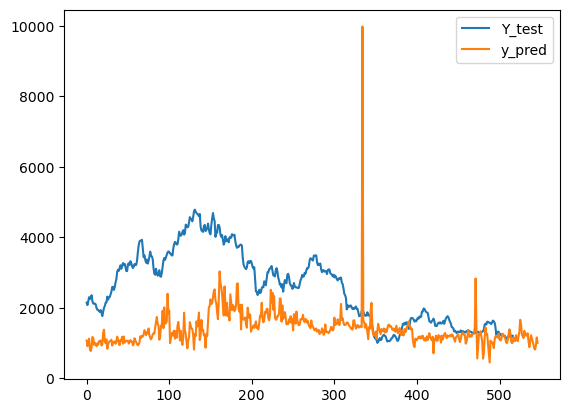

In [23]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [24]:
pre_df.to_csv("../result/LSTM/eth_NN.csv")

In [25]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'